In [ ]:
import os
import re
import sys
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../src")

import main

In [4]:
from skimage import color, transform, restoration, io, feature, img_as_ubyte
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
raw_image_path = '../data/raw/subset'
ip = main.ImagePipeline(raw_image_path)
ip.read()
for i in [64,32,16]:
    ip.resize(shape = (i,i,3))
    ip.grayscale()
    savename = 'gray_' + str(i)
    ip.save(savename)

'/tf/gal/repos/capstones/car-image-classification/notebooks/chevrolet_trailblazer_2005' does not exist

In [ ]:
# os.rmdir('../data/interim/image_data/gray_128/')

In [ ]:
# os.rmdir('../data/interim/image_data/gray_128/chevrolet_trailblazer_2005')

In [ ]:
ut_sub_dirs = os.listdir('../data/raw/subset')
keyword = 'gray_128'

In [ ]:
ut_sub_dirs

In [ ]:
cwd = os.getcwd()
type(cwd)

In [ ]:
sub_dir2 = os.path.join(cwd, os.path.join(cwd,'../data/interim/image_data/','gray_128'))

In [ ]:
os.path.split(sub_dir2)[0]

In [ ]:
os.path.split(os.path.join(cwd, os.path.join(cwd,'../data/interim/image_data/','gray_128')))[0]

In [ ]:
os.listdir(raw_image_path)

In [ ]:
# df = pd.read_pickle('../data/interim/numerical_data/scores_gray_x.pkl')

In [ ]:
i_sub = 'gray_64'

In [ ]:
ip = main.ImagePipeline('../data/interim/image_data/gray_64')

In [ ]:
ip.read()

In [ ]:
features, target = ip.vectorize()
print('splitting train/test \n')
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=0.2,
                                                    random_state=42)
rf_accuracy_lst = []
rf_precision_lst = []
rf_recall_lst = []
rf_num_trees_list = list(np.arange(100,1000,20))
rf_num_trees_list.extend(list(np.arange(1000,5000,200)))
# rf_num_trees_list = [10000]

for num_trees in rf_num_trees_list:
    print('RF',num_trees,'Classifying...', i_sub,'\n')
    rf = RandomForestClassifier(bootstrap=True,
                                ccp_alpha=0.0,
                                class_weight='balanced',  # default None
                                criterion='gini',
                                max_depth=None, #default None
                                max_features='auto',  # None = +-8% of % long rt
                                max_leaf_nodes=None,
                                max_samples=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0,
                                n_estimators=num_trees,  # two class=100=0.70, 1000=0.75,10k=0.74
                                n_jobs=-2,  # use all CPUs but 1
                                oob_score=True, # Use out-of-bag samples
                                random_state=1,
                                verbose=0,
                                warm_start=False
                                )
    print('RF Fitting...\n')
    rf.fit(X_train, y_train)
    print('Predicting...\n')
    rf_preds = rf.predict(X_test)
    print('Calculating Accuracy...\n')
    rf_accuracy_lst.append(accuracy_score(y_test, rf_preds))
    rf_precision_lst.append(precision_score(y_test, rf_preds, average='weighted'))
    rf_recall_lst.append(recall_score(y_test, rf_preds, average='weighted'))

In [ ]:
len(rf_accuracy_lst)

In [ ]:
len(rf_precision_lst)

In [ ]:
len(rf_recall_lst)

In [ ]:
len(rf_num_trees_list)

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), dpi=200)
ax.plot(rf_num_trees_list,rf_recall_lst)

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=200)
ax = fig.add_subplot(1, 1, 1)
ax.plot(rf_num_trees_list, 
        (rf_accuracy_lst), 
        label = 'acc',
        color = '#ffb65c'
        )

ax.plot(rf_num_trees_list, 
        (rf_precision_lst), 
        label = 'prec',
        color = '#f08400'
        )

ax.plot(rf_num_trees_list, 
        (rf_recall_lst), 
        label = 'rec',
        color = '#824800'
        )

# hline_height = df[['precision_gray_16', 
#                                 'precision_gray_32', 
#                                 'precision_gray_64']].max().max()
# plt.axhline(y=hline_height, linewidth=1,linestyle='--', color='k', alpha=0.3)
# plt.axvline(x=850, linewidth=2.5,linestyle='--', color='k', alpha=0.15)

plt.title('5 class random forest')
plt.xlabel('Number of Trees')
plt.ylabel('Precision                \nPercentage                 ', rotation='horizontal')
plt.legend(title='error metric')
plt.tight_layout()

In [ ]:
# dimensions of our images.
img_width, img_height = 128, 128
num_classes = 5

train_data_dir = '../data/interim/image_data/gray_'+ str(img_width)+'/train'
validation_data_dir = '../data/interim/image_data/gray_'+ str(img_width)+'/val'
nb_train_samples = 1200
nb_validation_samples = 300
num_epochs = 20
batch_size = 16

In [53]:
train_datagen = ImageDataGenerator(
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [7]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_width, img_height, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top (chop off head)

In [8]:
base_model.trainable = False

In [12]:
inputs = keras.Input(shape=(img_width, img_height, 3))
# We make sure that the base_model is running in inference mode,
# by passing `training=False`.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a 5 units (5 classes)
outputs = keras.layers.Dense(num_classes)(x)
model = keras.Model(inputs, outputs)

In [29]:
train_data_dir

'../data/interim/image_data/gray_128/train'

In [54]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    subset="training",
    batch_size=batch_size,
    class_mode="categorical"
    )

validation_generator = val_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    subset="validation",
    batch_size=batch_size,
    class_mode="categorical"
    )

test_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None #try None here
    )

Found 1200 images belonging to 5 classes.
Found 300 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [56]:
base_model.trainable = True


model.compile(optimizer=keras.optimizers.Adam(1e-4),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/20
75/75 [==============================] - 192s 3s/step - loss: 0.7902 - categorical_accuracy: 0.6850 - val_loss: 0.3749 - val_categorical_accuracy: 0.8567
Epoch 2/20
75/75 [==============================] - 175s 2s/step - loss: 0.3136 - categorical_accuracy: 0.8858 - val_loss: 0.3167 - val_categorical_accuracy: 0.8800
Epoch 3/20
75/75 [==============================] - 171s 2s/step - loss: 0.1585 - categorical_accuracy: 0.9483 - val_loss: 0.1212 - val_categorical_accuracy: 0.9600
Epoch 4/20
75/75 [==============================] - 176s 2s/step - loss: 0.0756 - categorical_accuracy: 0.9725 - val_loss: 0.1221 - val_categorical_accuracy: 0.9500
Epoch 5/20
75/75 [==============================] - 188s 3s/step - loss: 0.1098 - categorical_accuracy: 0.9633 - val_loss: 0.0246 - val_categorical_accuracy: 0.9933
Epoch 6/20
75/75 [==============================] - 198s 3s/step - loss: 0.0334 - categorical_accuracy: 0.9883 - val_loss: 0.0382 - val_categorical_accuracy: 0.9900
Epoch 7/20

In [43]:
# Learning rate of 1e-4 43% early epochs
# Learning rate of 1e-5 41% early epochs
# Learning rate of 1e-6 42% early epochs

model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator)

Epoch 1/20
57/75 [=====================>........] - ETA: 40s - loss: 1.8110 - categorical_accuracy: 0.2039

KeyboardInterrupt: 

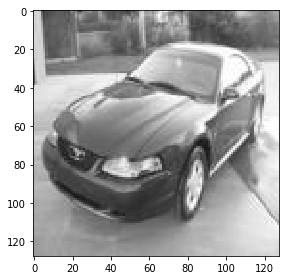

In [58]:
img1_dir = '../data/interim/image_data/gray_128/ford_mustang_2003/00V0V_cIug9rFQXkY_600x450.jpg'
io.imshow(img1_dir)

In [60]:
img1 = io.imread(img1_dir)
img1

Array([[212, 211, 213, ..., 160, 160, 157],
       [212, 212, 216, ..., 161, 166, 166],
       [210, 210, 218, ..., 153, 160, 161],
       ...,
       [156, 156, 157, ..., 218, 215, 212],
       [154, 154, 155, ..., 216, 214, 211],
       [152, 152, 153, ..., 217, 215, 214]], dtype=uint8)

In [ ]:
model.predict(img1)

In [ ]:
# to make train / val(test) folders
split_folders.ratio('../data/interim/image_data/gray_64', output="../data/interim/image_data/gray_64", seed=42, ratio=(.8, .2))

In [ ]:
# t_sub_dirs = ['gray_16', 'gray_32', 'gray_64']
# ip2 = main.ImagePipeline(os.path.join('../data/interim/image_data',t_sub_dirs[0]))

In [ ]:
features, target = ip.vectorize()
X_train, 
X_test, 
y_train, 
y_test = train_test_split(features, target,
                            test_size=0.2,
                            random_state=42)

In [ ]:
# dimensions of our images.
img_width, img_height = 128, 128

train_data_dir = '../data/interim/image_data/gray_128/train'
validation_data_dir = '../data/interim/image_data/gray_128/val'
nb_train_samples = 1200
nb_validation_samples = 300
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1.,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1.)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('x_try_128.h5')

In [ ]:

Create_Model(df=df_eval_trans, transformed_sub_dirs = ['gray_16', 'gray_32', 'gray_64'], s=(64,64,3))


print('plotting...\n\n')
plot_accuracies(df_eval_trans)
plot_precisions(df_eval_trans)
plot_recalls(df_eval_trans)